In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
from scipy.special import digamma, gamma, logsumexp, expit
from scipy.stats import norm, gamma, bernoulli
import torch
import torch.distributions as dist
from torch import nn
# from torchvision import datasets, transforms
import torch.nn.functional as F
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
%config InlineBackend.figure_format = 'retina'

# Plannar flows

In [3]:
class Planar(nn.Module):
    def __init__(self, size=1, init_sigma=0.01):
        super().__init__()
        self.u = nn.Parameter(torch.randn(1, size).normal_(0, init_sigma))
        self.w = nn.Parameter(torch.randn(1, size).normal_(0, init_sigma))
        self.b = nn.Parameter(torch.zeros(1))

    @property
    def normalized_u(self):
        """
        Needed for invertibility condition.

        See Appendix A.1
        Rezende et al. Variational Inference with Normalizing Flows
        https://arxiv.org/pdf/1505.05770.pdf
        """

        # softplus
        def m(x):
            return -1 + torch.log(1 + torch.exp(x))

        wtu = torch.matmul(self.w, self.u.t())
        w_div_w2 = self.w / torch.norm(self.w)
        return self.u + (m(wtu) - wtu) * w_div_w2

    def psi(self, z):
        """
        ψ(z) =h′(w^tz+b)w

        See eq(11)
        Rezende et al. Variational Inference with Normalizing Flows
        https://arxiv.org/pdf/1505.05770.pdf
        """
        return self.h_prime(z @ self.w.t() + self.b) @ self.w

    def h(self, x):
        return torch.tanh(x)

    def h_prime(self, z):
        return 1 - torch.tanh(z) ** 2

    def forward(self, z):
        if isinstance(z, tuple):
            z, accumulating_ldj = z
        else:
            z, accumulating_ldj = z, 0
        psi = self.psi(z)

        u = self.normalized_u

        # determinant of jacobian
        det = (1 + psi @ u.t())

        # log |det Jac|
        ldj = torch.log(torch.abs(det) + 1e-6)

        wzb = z @ self.w.t() + self.b

        fz = z + (u * self.h(wzb))

        return fz, ldj + accumulating_ldj

In [4]:
class Flow(nn.Module):
    def __init__(self, dim=2, n_flows=10):
        super().__init__()
        self.flow = nn.Sequential(*[
            Planar(dim) for _ in range(n_flows)
        ])
        self.mu = nn.Parameter(torch.randn(dim, ).normal_(0, 0.01))
        self.log_var = nn.Parameter(torch.randn(dim, ).normal_(1, 0.01))

    def forward(self, shape):
        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn(shape)  # unit gaussian
        z0 = self.mu + eps * std

        zk, ldj = self.flow(z0)
        return z0, zk, ldj, self.mu, self.log_var

# Hierarchical model - only user

In [242]:
np.random.seed(123)

sg = 0.5
mu = -4

n_u = 20
n_obs_per_u = 100
n_obs = n_obs_per_u*n_u

u = np.concatenate([np.zeros(n_obs_per_u, dtype=int) + i for i in range(n_u)])
theta_u = np.random.normal(mu, sg, size=n_u)   

x = np.random.uniform(0.1, 100, size=n_obs)
rd = np.random.random(size=n_obs)

y = np.zeros(shape=n_obs, dtype=float)

theta = theta_u[u]

rate = np.exp(theta)
exponent = - rate * x
p = np.exp(exponent)
y[:] = p > rd

In [243]:
print("mean alpha", np.mean(theta))
print("mean std", np.std(theta))

mean alpha -3.9427911340223547
mean std 0.6128066343702181


## Inference for each user separately

In [7]:
def det_loss(x, y, mu, log_var, z_0, z_k, ldj):
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    # batch_size = z_0.size(0)

    # Qz0
    log_qz0 = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z_0)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk = log_qz0.sum() - ldj.sum()
    
    # P(x|z)
    log_p = -torch.exp(z_k[:, 0])*x
    nll = - dist.Bernoulli(probs=torch.exp(log_p)).log_prob(y).sum()
    
    return log_qzk + nll 

In [8]:
def train_flow(x, y, flow, shape, epochs=1000, verbose=False):
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)

    for i in range(epochs):
        z0, zk, ldj, mu, log_var = flow(shape=shape)
        loss = det_loss(x=x,
                        y=y,
                        mu=mu,
                        log_var=log_var,
                        z_0=z0,
                        z_k=zk,
                        ldj=ldj)
        loss.backward()
        optim.step()
        optim.zero_grad()
        if i % 250 == 0 and verbose:
            print(loss.item())


In [9]:
alpha_u = np.zeros(n_u)
for i in tqdm(range(n_u)):
    y_u = y[u==i]
    x_u = x[u==i]
    flow = Flow(dim=1, n_flows=6)
    shape = (1, 1)
    train_flow(x=torch.from_numpy(x_u), y=torch.from_numpy(y_u), flow=flow, shape=shape, epochs=1000)
    z0, zk, ldj, mu, log_var = flow((5000, 1))
    alpha_samples = np.array(zk.data[:, 0])
    alpha_u[i] = np.mean(alpha_samples)

100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


In [10]:
print(np.mean(alpha_u))
print(np.std(alpha_u))

-3.968748593330383
0.5804048818326202


## Inference over all users in the same time - Q(Z) only

In [11]:
def det_loss(x, y, mu, log_var, z_0, z_k, ldj):
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    # batch_size = z_0.size(0)

    # Qz0
    log_qz0 = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z_0)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk = log_qz0.sum() - ldj.sum()
    
    # P(x|z)
    ll = torch.zeros(n_u)
    for i in range(n_u):
        a = z_k[i, 0]
        y_u = y[u==i]
        x_u = x[u==i]
        log_p = -torch.exp(a)*x_u
        ll[i] = dist.Bernoulli(probs=torch.exp(log_p)).log_prob(y_u).sum()

    nll = - ll.sum()
    
    return log_qzk + nll 

In [22]:
def train_flow(x, y, flow, shape, epochs=1000):
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)
    
    with tqdm(total=epochs) as pbar:
        for i in range(epochs):
            z0, zk, ldj, mu, log_var = flow(shape=shape)
            loss = det_loss(x=x,
                            y=y,
                            mu=mu,
                            log_var=log_var,
                            z_0=z0,
                            z_k=zk,
                            ldj=ldj)
            loss.backward()
            optim.step()
            optim.zero_grad()
            if i % 100 == 0 and verbose:
                pbar.set_postfix({'loss': loss.item()})
            pbar.update()


In [23]:
flow = Flow(dim=1, n_flows=16)
shape = (n_u, 1)
train_flow(x=torch.from_numpy(x), y=torch.from_numpy(y), flow=flow, shape=shape, epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [24]:
z0, zk, ldj, mu, log_var = flow((5000, 1))
alpha_samples = np.array(zk.data[:, 0])
print(np.mean(alpha_samples))
print(np.std(alpha_samples))

-3.9760933
0.16366829


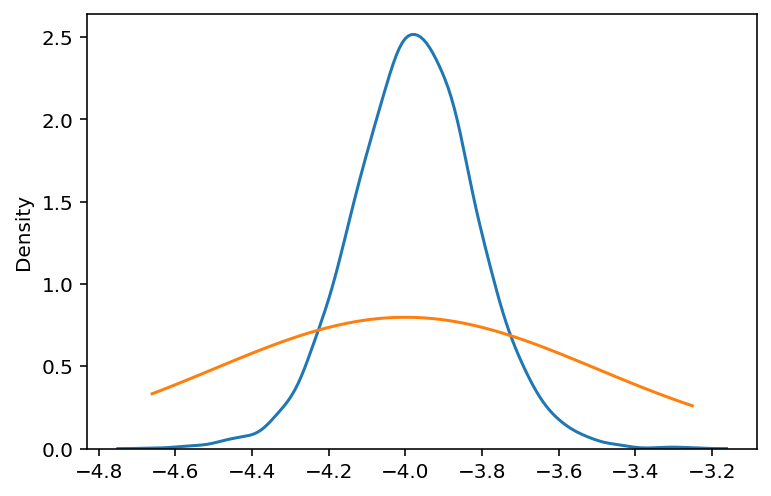

In [25]:
fig, ax = plt.subplots() 
sns.kdeplot(alpha_samples, ax=ax)
x_plot = np.linspace(np.min(alpha_samples), np.max(alpha_samples), 100)
ax.plot(x_plot, stats.norm(loc=-4, scale=0.5).pdf(x_plot))

## Inference over all users in the same time - Q(theta) only

In [26]:
def det_loss(x, y, mu, log_var, z_0, z_k, ldj):
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    # batch_size = z_0.size(0)

    # Qz0
    log_qz0 = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z_0)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk = log_qz0.sum() - ldj.sum()
    
    mu_alpha = z_k[0, 0]
    sigma_alpha = torch.exp(0.5*z_k[0, 1]) 
    eps = torch.randn(n_u)
    a = mu_alpha + eps * sigma_alpha
    
    # P(x|z)
    ll = torch.zeros(n_u)
    for i in range(n_u):
        a_i = a[i]
        y_u = y[u==i]
        x_u = x[u==i]
        log_p = -torch.exp(a_i)*x_u
        ll[i] = dist.Bernoulli(probs=torch.exp(log_p)).log_prob(y_u).sum()

    nll = - ll.sum()
    
    return log_qzk + nll 

In [27]:
def train_flow(x, y, flow, shape, epochs=1000):
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)
    
    with tqdm(total=epochs) as pbar:
        for i in range(epochs):
            z0, zk, ldj, mu, log_var = flow(shape=shape)
            loss = det_loss(x=x,
                            y=y,
                            mu=mu,
                            log_var=log_var,
                            z_0=z0,
                            z_k=zk,
                            ldj=ldj)
            loss.backward()
            optim.step()
            optim.zero_grad()
            if i % 100 == 0:
                pbar.set_postfix({'loss': loss.item()})
            pbar.update()


In [29]:
n_dim = 2
flow = Flow(dim=n_dim, n_flows=16)
shape = (1, n_dim)
train_flow(x=torch.from_numpy(x), y=torch.from_numpy(y), flow=flow, shape=shape, epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [30]:
z0, zk, ldj, mu, log_var = flow((5000, n_dim))

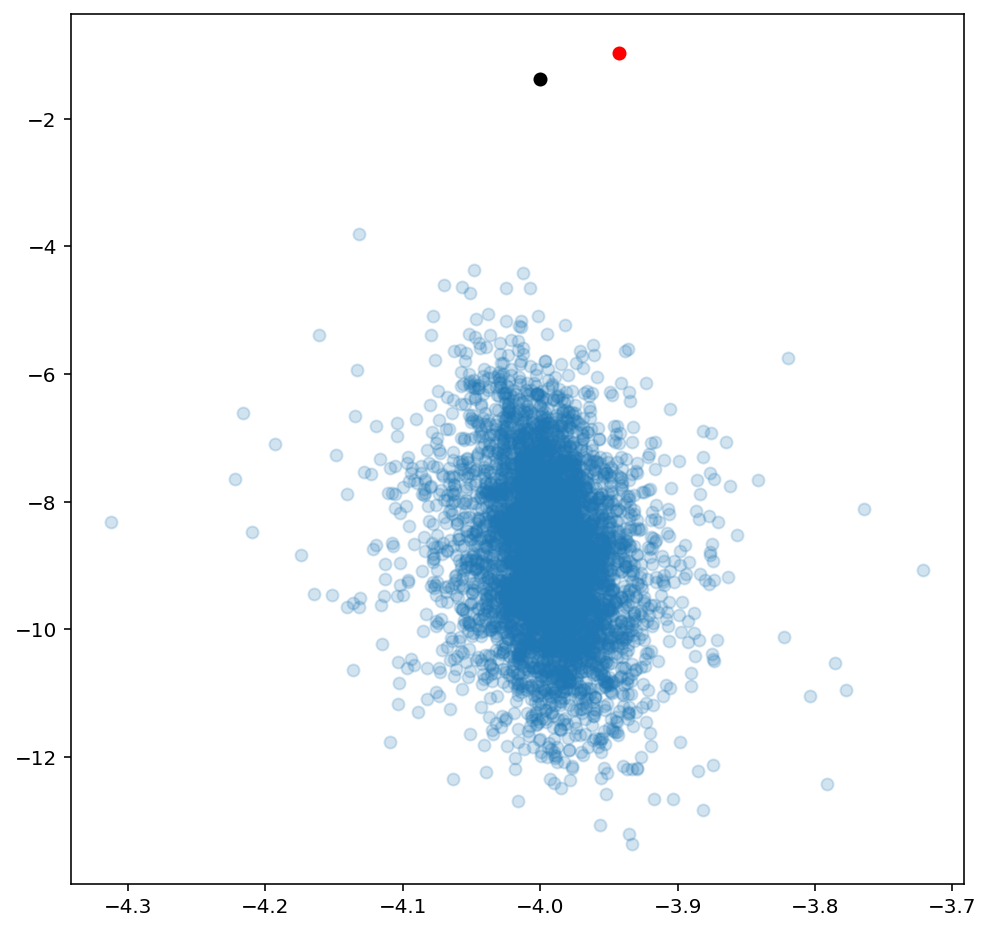

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(zk.data[:, 0], zk.data[:, 1], color='C0', alpha=0.2)

# Plot truth
ax.scatter(-4, np.log(0.5**2), color='black', alpha=1)
ax.scatter(np.mean(theta), np.log(np.std(theta)**2), color='red', alpha=1)

## Inference over all users in the same time - Q(Z) Q(theta) 

In [244]:
class MultipleFlow(nn.Module):
    
    def __init__(self, dim_Z, dim_theta, n_flows=10):
        super().__init__()
        self.flow_Z = nn.Sequential(*[
            Planar(dim_Z) for _ in range(n_flows)
        ])
        self.mu_Z = nn.Parameter(torch.randn(dim_Z, ).normal_(0, 0.01))
        self.log_var_Z = nn.Parameter(torch.randn(dim_Z, ).normal_(1, 0.01))
        
        self.flow_theta = nn.Sequential(*[
            Planar(dim_theta) for _ in range(n_flows)
        ])
        
        self.mu_theta = nn.Parameter(torch.randn(dim_theta, ).normal_(0, 0.01))
        self.log_var_theta = nn.Parameter(torch.randn(dim_theta, ).normal_(1, 0.01))

    def forward(self, shape_Z, shape_theta):
        std_Z = torch.exp(0.5 * self.log_var_Z)
        eps_Z = torch.randn(shape_Z)  # unit gaussian
        z0_Z = self.mu_Z + eps_Z * std_Z
        zk_Z, ldj_Z = self.flow_Z(z0_Z)
        
        std_theta = torch.exp(0.5 * self.log_var_theta)
        eps_theta = torch.randn(shape_theta)  # unit gaussian
        z0_theta = self.mu_theta + eps_theta * std_theta
        zk_theta, ldj_theta = self.flow_theta(z0_theta)
        return (z0_Z, zk_Z, ldj_Z, self.mu_Z, self.log_var_Z, 
                z0_theta, zk_theta, ldj_theta, self.mu_theta, self.log_var_theta)

In [245]:
def det_loss(x, y, flow):
    
    z0_Z, zk_Z, ldj_Z, mu_Z, log_var_Z, \
        z0_theta, zk_theta, ldj_theta, mu_theta, log_var_theta = flow(shape_Z=(1, n_u),
                                                                      shape_theta=(1, 2))
    
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    # batch_size = z_0.size(0)

    # Qz0
    log_qz0_Z = dist.Normal(mu_Z, torch.exp(0.5 * log_var_Z)).log_prob(z0_Z)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk_Z = log_qz0_Z.sum() - ldj_Z.sum()
    
    # Qz0
    log_qz0_theta = dist.Normal(mu_theta, torch.exp(0.5 * log_var_theta)).log_prob(z0_theta)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk_theta = log_qz0_theta.sum() - ldj_theta.sum()
    
    # P(x|z)
    Zu = zk_Z[0, :]
    Z = Zu[u]
    log_p = -torch.exp(Z)*x
    nll = - dist.Bernoulli(probs=torch.exp(log_p)).log_prob(y).sum()
    
    mu = zk_theta[0, 0]
    log_var = zk_theta[0, 1]
    
    nll_Z = -dist.Normal(mu, torch.exp(0.5*log_var)).log_prob(Zu).sum()
    
    return log_qzk_Z + log_qzk_theta + nll + nll_Z 

In [246]:
def train_flow(x, y, epochs=1000):
    
    flow = MultipleFlow(dim_Z=n_u, dim_theta=2, n_flows=16)
    
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)
    
    with tqdm(total=epochs) as pbar:
        for i in range(epochs):
        
            loss = det_loss(x=x, y=y, flow=flow)
            loss.backward()
            optim.step()
            optim.zero_grad()
            if i % 100 == 0:
                pbar.set_postfix({'loss': loss.item()})
            pbar.update()
    return flow


In [247]:
flow = train_flow(x=torch.from_numpy(x), y=torch.from_numpy(y), epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [248]:
z0_Z, zk_Z, ldj_Z, mu_Z, log_var_Z, \
    z0_theta, zk_theta, ldj_theta, mu_theta, log_var_theta = flow(shape_Z=(5000, n_u), shape_theta=(5000, 2))

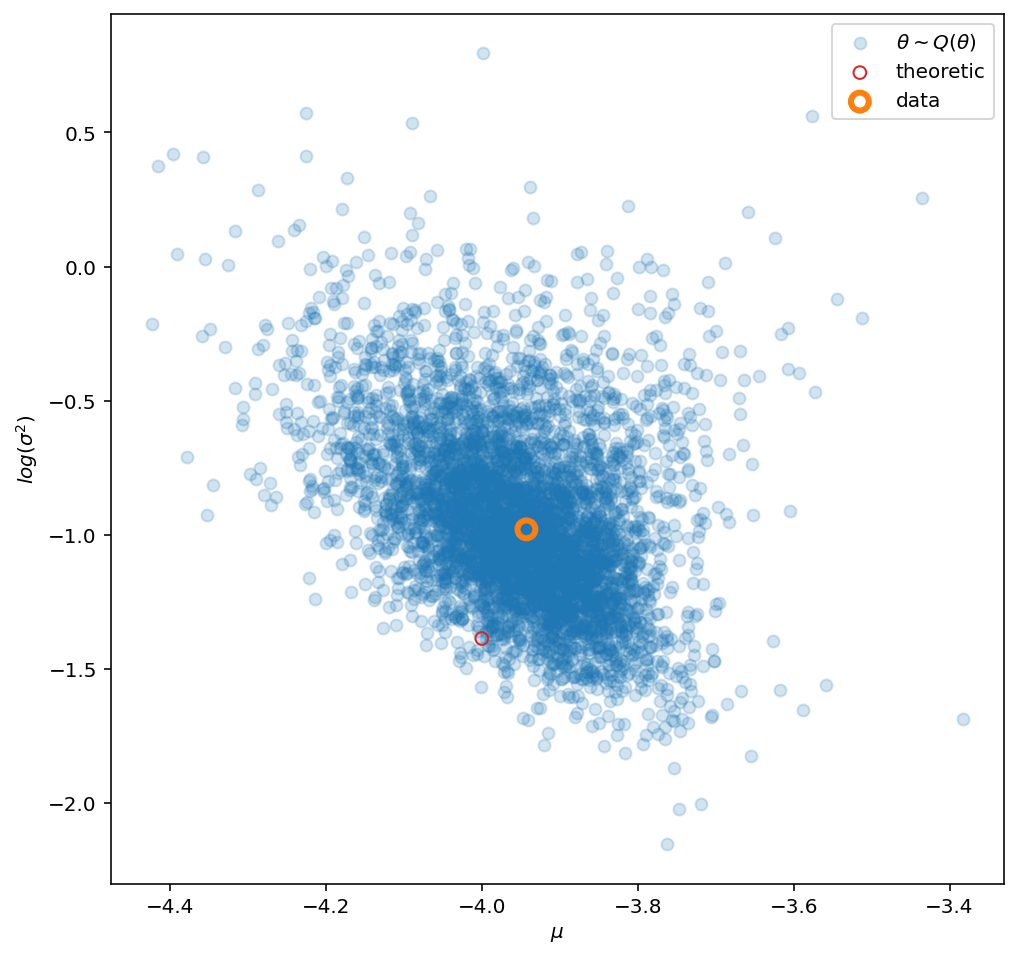

In [249]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(zk_theta.data[:, 0], zk_theta.data[:, 1], color='C0', alpha=0.2, label=r"$\theta \sim Q(\theta)$")

# Plot truth
ax.scatter(-4, np.log(0.5**2), edgecolors='C3', alpha=1, label='theoretic', facecolors='none', s=40)
ax.scatter(np.mean(theta), np.log(np.std(theta)**2), facecolors='none', edgecolors='C1', alpha=1, s=80,
          linewidths=3, label="data")
ax.set_xlabel("$\mu$")
ax.set_ylabel("$log(\sigma^2)$")
ax.legend();

# Hierarchical modeling - both user and item

In [252]:
np.random.seed(1234)

sg_u = 0.5
sg_w = 1.0
mu = -4

n_u = 20
n_w = 20
n_obs_per_wu = 20
n_obs = n_obs_per_wu*n_u*n_w

u = np.concatenate([np.zeros(n_obs_per_wu*n_w, dtype=int) + i for i in range(n_u)])
w = np.tile(np.concatenate([np.zeros(n_obs_per_wu, dtype=int) + i for i in range(n_w)]), n_u)

Zu = np.random.normal(0, sg_u, size=n_u) 
Zw = np.random.normal(0, sg_w, size=n_w) 

x = np.random.uniform(0.1, 100, size=n_obs)
rd = np.random.random(size=n_obs)

y = np.zeros(shape=n_obs, dtype=float)

Z = mu + Zu[u] + Zw[w]

rate = np.exp(Z)
p = np.exp(-rate*x)
y[:] = p > rd

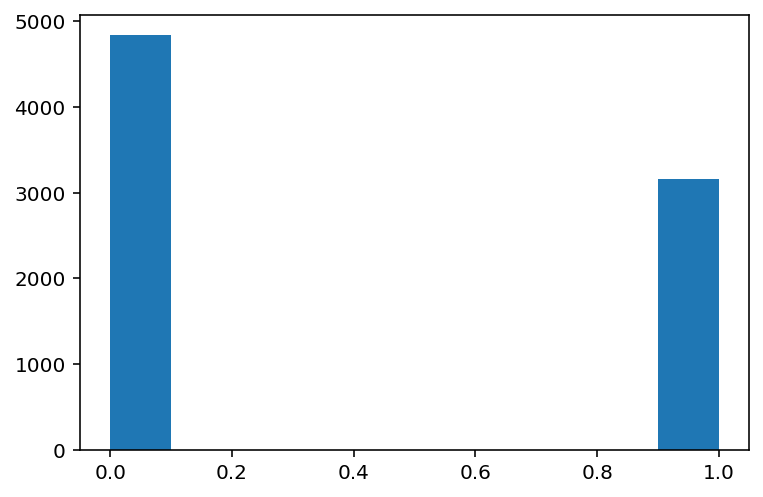

In [253]:
plt.hist(y);

In [254]:
print("n_obs", n_obs)
print("sigma Zu", np.std(Zu))
print("sigma Zw", np.std(Zw))
print("mu Z", np.mean(Z))  # np.mean(mu + Zu + Zw)

n_obs 8000
sigma Zu 0.5369771468717787
sigma Zw 0.8798483035728747
mu Z -3.691610034906642


In [256]:
def det_loss(x, y, flow):
    
    z0_Z, zk_Z, ldj_Z, mu_Z, log_var_Z, \
        z0_theta, zk_theta, ldj_theta, mu_theta, log_var_theta = flow(shape_Z=(1, n_u+n_w),
                                                                      shape_theta=(1, 3))
    
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    # batch_size = z_0.size(0)

    # Qz0
    log_qz0_Z = dist.Normal(mu_Z, torch.exp(0.5 * log_var_Z)).log_prob(z0_Z)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk_Z = log_qz0_Z.sum() - ldj_Z.sum()
    
    # Qz0
    log_qz0_theta = dist.Normal(mu_theta, torch.exp(0.5 * log_var_theta)).log_prob(z0_theta)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk_theta = log_qz0_theta.sum() - ldj_theta.sum()
    
    # P(x|z)
    Zu = zk_Z[0, :n_u]
    Zw = zk_Z[0, n_u:]
    Z = Zu[u] + Zw[w]
    log_p = -torch.exp(Z)*x
    nll = - dist.Bernoulli(probs=torch.exp(log_p)).log_prob(y).sum()
    
    mu = zk_theta[0, 0]
    log_var_u = zk_theta[0, 1]
    log_var_w = zk_theta[0, 2]
    
    nll_Zu = -dist.Normal(mu, torch.exp(0.5*log_var_u)).log_prob(Zu).sum()
    nll_Zw = -dist.Normal(mu, torch.exp(0.5*log_var_w)).log_prob(Zw).sum()
    
    return log_qzk_Z + log_qzk_theta + nll + nll_Zu + nll_Zw 

In [257]:
def train_flow(x, y, epochs=1000):
    
    flow = MultipleFlow(dim_Z=n_u+n_w, dim_theta=3, n_flows=16)
    
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)
    
    with tqdm(total=epochs) as pbar:
        for i in range(epochs):
        
            loss = det_loss(x=x, y=y, flow=flow)
            loss.backward()
            optim.step()
            optim.zero_grad()
            if i % 100 == 0:
                pbar.set_postfix({'loss': loss.item()})
            pbar.update()
    return flow


In [259]:
flow = train_flow(x=torch.from_numpy(x), y=torch.from_numpy(y), epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [260]:
z0_Z, zk_Z, ldj_Z, mu_Z, log_var_Z, \
    z0_theta, zk_theta, ldj_theta, mu_theta, log_var_theta = flow(shape_Z=(5000, n_u+n_w), 
                                                                  shape_theta=(5000, 3))

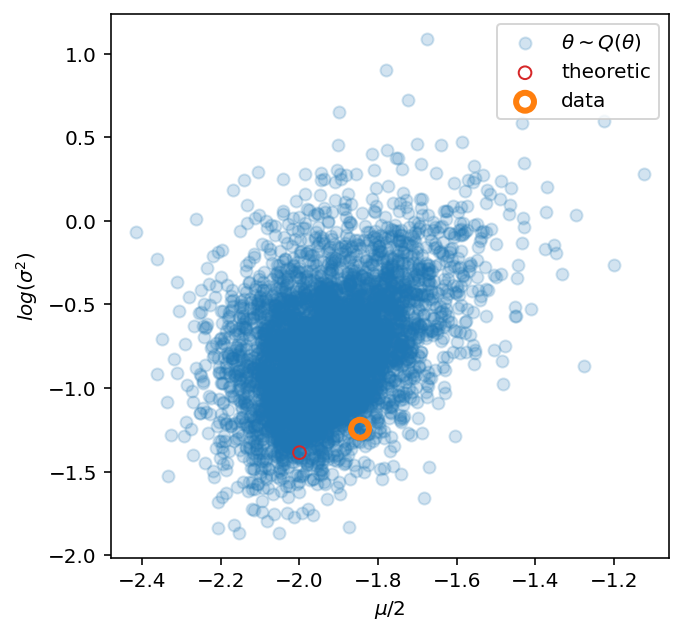

In [264]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(zk_theta.data[:, 0], zk_theta.data[:, 1], color='C0', alpha=0.2, label=r"$\theta \sim Q(\theta)$")

# Plot truth
ax.scatter(mu/2, np.log(sg_u**2), edgecolors='C3', alpha=1, label='theoretic', facecolors='none', s=40)
ax.scatter(np.mean(Z)/2, np.log(np.std(Zu)**2), facecolors='none', edgecolors='C1', alpha=1, s=80,
          linewidths=3, label="data")
ax.set_xlabel("$\mu /2$")
ax.set_ylabel("$log(\sigma^2)$")
ax.legend();

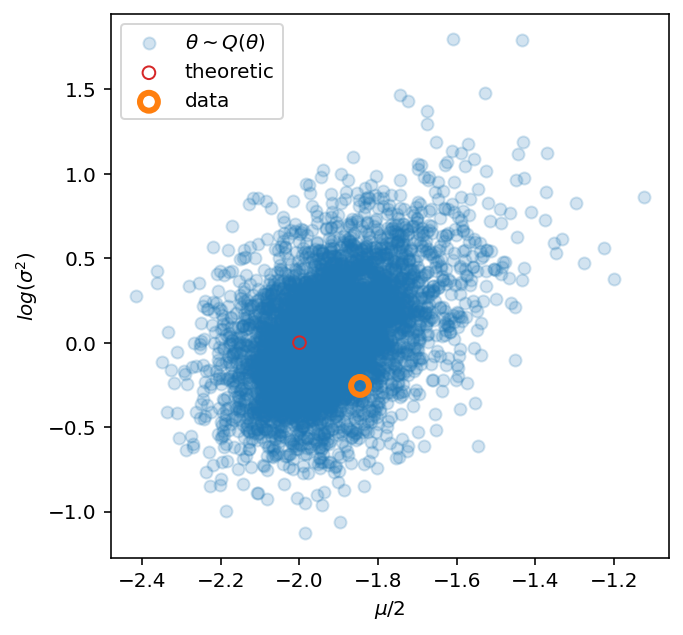

In [266]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(zk_theta.data[:, 0], zk_theta.data[:, 2], color='C0', alpha=0.2, label=r"$\theta \sim Q(\theta)$")

# Plot truth
ax.scatter(mu/2, np.log(sg_w**2), edgecolors='C3', alpha=1, label='theoretic', facecolors='none', s=40)
ax.scatter(np.mean(Z)/2, np.log(np.std(Zw)**2), facecolors='none', edgecolors='C1', alpha=1, s=80,
          linewidths=3, label="data")
ax.set_xlabel("$\mu/2$")
ax.set_ylabel("$log(\sigma^2)$")
ax.legend();

# Hierarchical modeling - Two parameters model

In [292]:
# Seed
np.random.seed(0)

sg_u = 0.5, 0.2
sg_w = 1.0, 0.4
mu = -4., -2.

n_u = 20
n_w = 20
n_obs_per_wu = 50
n_obs = n_obs_per_wu*n_u*n_w

u = np.concatenate([np.zeros(n_obs_per_wu*n_w, dtype=int) + i for i in range(n_u)])
w = np.tile(np.concatenate([np.zeros(n_obs_per_wu, dtype=int) + i for i in range(n_w)]), n_u)

r = np.zeros(n_obs, dtype=float)
r[:] = np.tile(np.concatenate([np.arange(n_obs_per_wu, dtype=int) for _ in range(n_w)]), n_u)

Zu = np.random.normal(np.zeros(2), sg_u, size=(n_u, 2)) 
Zw = np.random.normal(np.zeros(2), sg_w, size=(n_w, 2)) 

x = np.random.uniform(50, 1000, size=n_obs)
rd = np.random.random(size=n_obs)

y = np.zeros(shape=n_obs, dtype=float)

Z = mu + Zu[u] + Zw[w]

a = np.exp(Z[:, 0])
b = expit(Z[:, 1])
neg_rate = - a * x * (1-b)**r
p = np.exp(neg_rate)
y[:] = p > rd

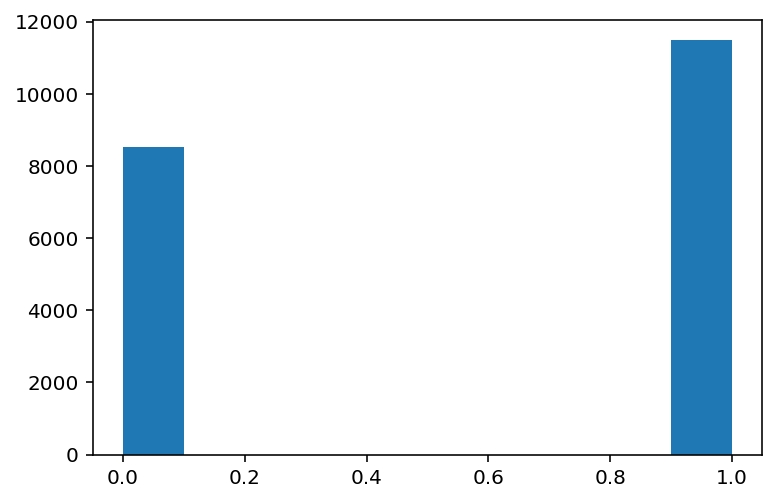

In [293]:
plt.hist(y);

In [294]:
b_smp = np.random.normal(loc=-2, scale=0.3, size=1000)

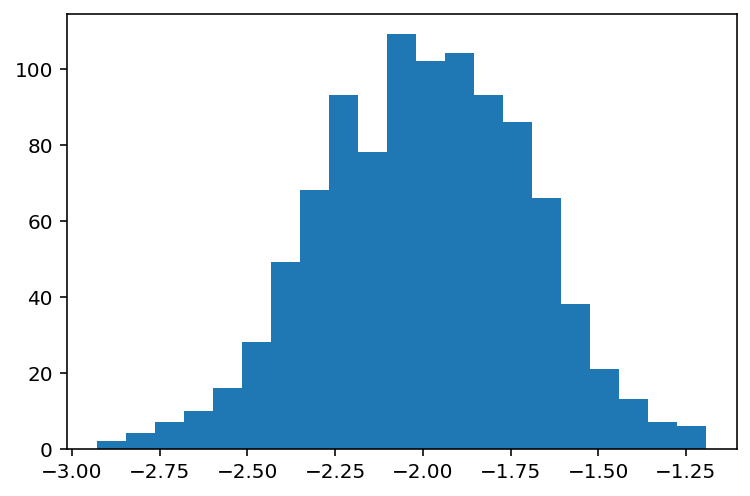

In [295]:
plt.hist(b_smp, bins='auto');

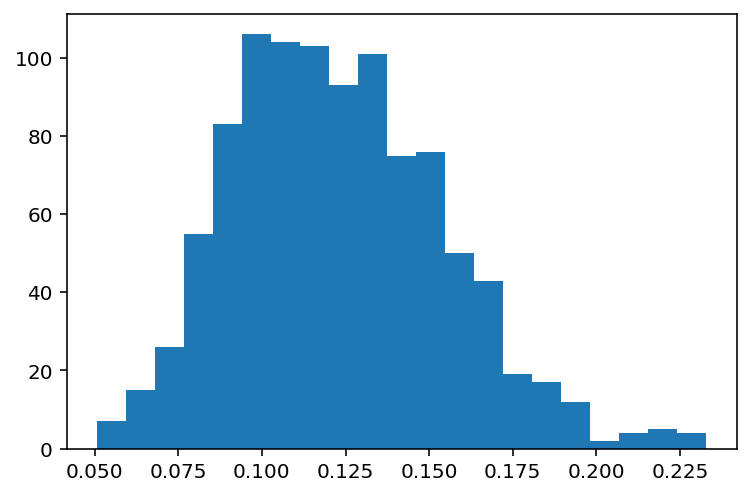

In [296]:
plt.hist(expit(b_smp), bins='auto');

In [297]:
print(len(y))

20000


In [298]:
print("sg_u", np.std(Zu, axis=0))
print("sg_w", np.std(Zw, axis=0))
print("mu", np.mean(Z, axis=0))

sg_u [0.54099092 0.2003145 ]
sg_w [0.75688435 0.33018865]
mu [-4.28114954 -2.06142483]


In [299]:
def det_loss(x, y, r, flow):
    
    z0_Z, zk_Z, ldj_Z, mu_Z, log_var_Z, \
        z0_theta, zk_theta, ldj_theta, mu_theta, log_var_theta = flow(shape_Z=(1, (n_u+n_w)*2),
                                                                      shape_theta=(1, 3*2))
    
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    # batch_size = z_0.size(0)

    # Qz0
    log_qz0_Z = dist.Normal(mu_Z, torch.exp(0.5 * log_var_Z)).log_prob(z0_Z)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk_Z = log_qz0_Z.sum() - ldj_Z.sum()
    
    # Qz0
    log_qz0_theta = dist.Normal(mu_theta, torch.exp(0.5 * log_var_theta)).log_prob(z0_theta)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk_theta = log_qz0_theta.sum() - ldj_theta.sum()
    
    # P(x|z)
    Zu1 = zk_Z[0, :n_u]
    Zw1 = zk_Z[0, n_u:n_w+n_u]
    
    Zu2 = zk_Z[0, n_w+n_u:n_w+n_u*2]
    Zw2 = zk_Z[0, n_w+n_u*2:]
    
    Z1 = Zu1[u] + Zw1[w]
    Z2 = Zu2[u] + Zw2[w]
    
    a = torch.exp(Z1)
    b = torch.sigmoid(Z2)
    
    log_p = -a*x*(1-b)**r
    nll = -dist.Bernoulli(probs=torch.exp(log_p)).log_prob(y).sum()
    
    mu1 = zk_theta[0, 0]
    log_var_u1 = zk_theta[0, 1]
    log_var_w1 = zk_theta[0, 2]
    
    mu2 = zk_theta[0, 3]
    log_var_u2 = zk_theta[0, 4]
    log_var_w2 = zk_theta[0, 5]
    
    nll_Zu1 = -dist.Normal(mu1, torch.exp(0.5*log_var_u1)).log_prob(Zu1).sum()
    nll_Zw1 = -dist.Normal(mu1, torch.exp(0.5*log_var_w1)).log_prob(Zw1).sum()
    
    nll_Zu2 = -dist.Normal(mu2, torch.exp(0.5*log_var_u2)).log_prob(Zu2).sum()
    nll_Zw2 = -dist.Normal(mu2, torch.exp(0.5*log_var_w2)).log_prob(Zw2).sum()
    
    return log_qzk_Z + log_qzk_theta + nll + nll_Zu1 + nll_Zw1 + nll_Zu2 + nll_Zw2

In [300]:
def train_flow(x, y, r, epochs=1000):
    
    flow = MultipleFlow(dim_Z=(n_u+n_w)*2, dim_theta=5, n_flows=16)
    
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)
    
    with tqdm(total=epochs) as pbar:
        for i in range(epochs):
        
            loss = det_loss(x=x, y=y,r=r, flow=flow)
            loss.backward()
            optim.step()
            optim.zero_grad()
            if i % 100 == 0:
                pbar.set_postfix({'loss': loss.item()})
            pbar.update()
    return flow


In [301]:
flow = train_flow(x=torch.from_numpy(x), y=torch.from_numpy(y), 
                  r=torch.from_numpy(r),
                  epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [302]:
z0_Z, zk_Z, ldj_Z, mu_Z, log_var_Z, \
    z0_theta, zk_theta, ldj_theta, mu_theta, log_var_theta = flow(shape_Z=(5000, (n_u+n_w)*2), 
                                                                  shape_theta=(5000, 3*2))

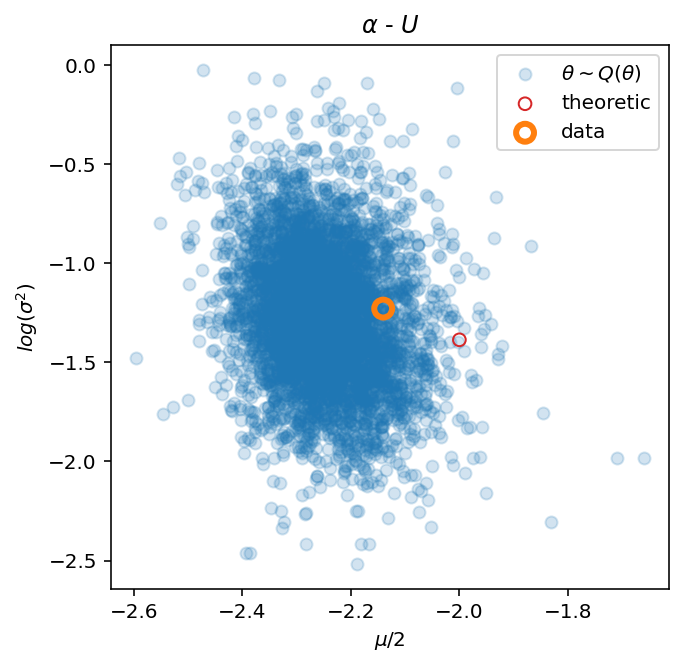

In [311]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.set_title(r"$\alpha$ - $U$")

ax.scatter(zk_theta.data[:, 0], zk_theta.data[:, 1], 
           color='C0', alpha=0.2, label=r"$\theta \sim Q(\theta)$")

# Plot truth
ax.scatter(mu[0]/2, np.log(sg_u[0]**2), edgecolors='C3', alpha=1, 
           label='theoretic', facecolors='none', s=40)
ax.scatter(np.mean(Z[:, 0])/2, np.log(np.std(Zu[:, 0])**2), 
           facecolors='none', edgecolors='C1', alpha=1, s=80,
           linewidths=3, label="data")
ax.set_xlabel("$\mu /2$")
ax.set_ylabel("$log(\sigma^2)$")
ax.legend();

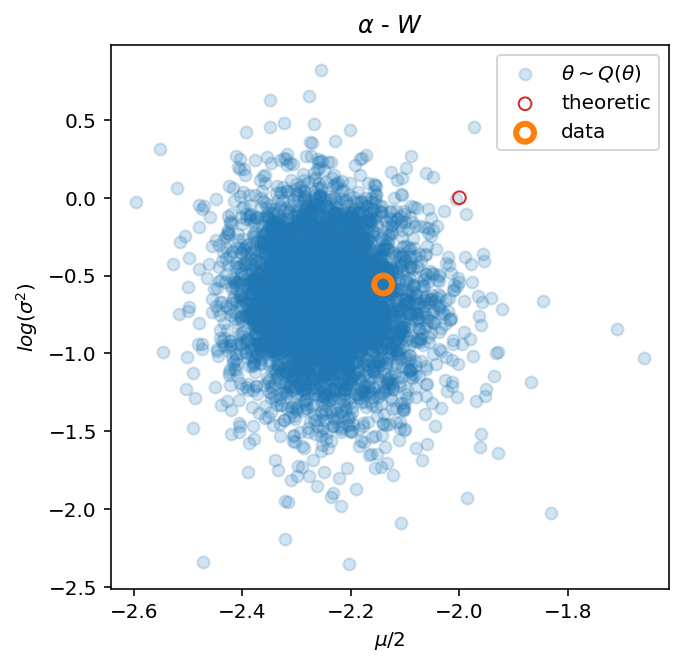

In [312]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.set_title(r"$\alpha$ - $W$")

ax.scatter(zk_theta.data[:, 0], zk_theta.data[:, 2], 
           color='C0', alpha=0.2, label=r"$\theta \sim Q(\theta)$")

# Plot truth
ax.scatter(mu[0]/2, np.log(sg_w[0]**2), edgecolors='C3', alpha=1, 
           label='theoretic', facecolors='none', s=40)
ax.scatter(np.mean(Z[:, 0])/2, np.log(np.std(Zw[:, 0])**2), 
           facecolors='none', edgecolors='C1', alpha=1, s=80,
           linewidths=3, label="data")
ax.set_xlabel("$\mu /2$")
ax.set_ylabel("$log(\sigma^2)$")
ax.legend();

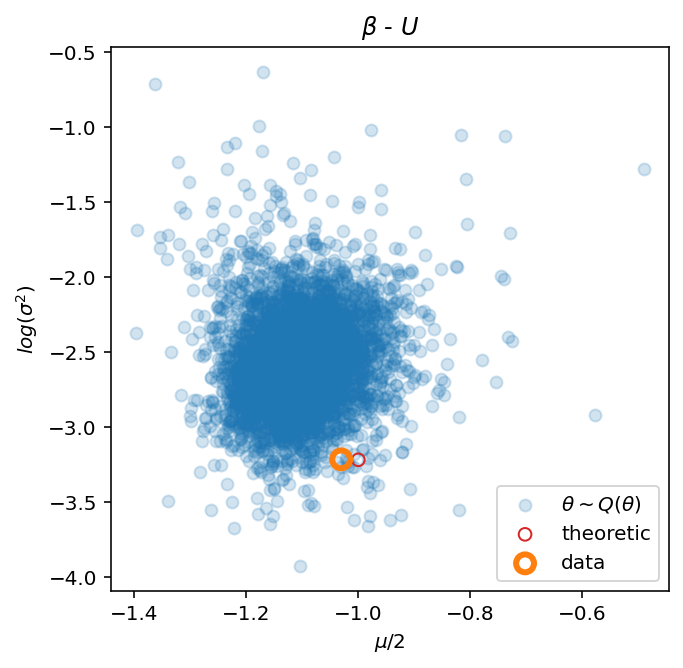

In [313]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.set_title(r"$\beta$ - $U$")

ax.scatter(zk_theta.data[:, 3], zk_theta.data[:, 4], 
           color='C0', alpha=0.2, label=r"$\theta \sim Q(\theta)$")

# Plot truth
ax.scatter(mu[1]/2, np.log(sg_u[1]**2), edgecolors='C3', alpha=1, 
           label='theoretic', facecolors='none', s=40)
ax.scatter(np.mean(Z[:, 1])/2, np.log(np.std(Zu[:, 1])**2), 
           facecolors='none', edgecolors='C1', alpha=1, s=80,
           linewidths=3, label="data")
ax.set_xlabel("$\mu /2$")
ax.set_ylabel("$log(\sigma^2)$")
ax.legend();

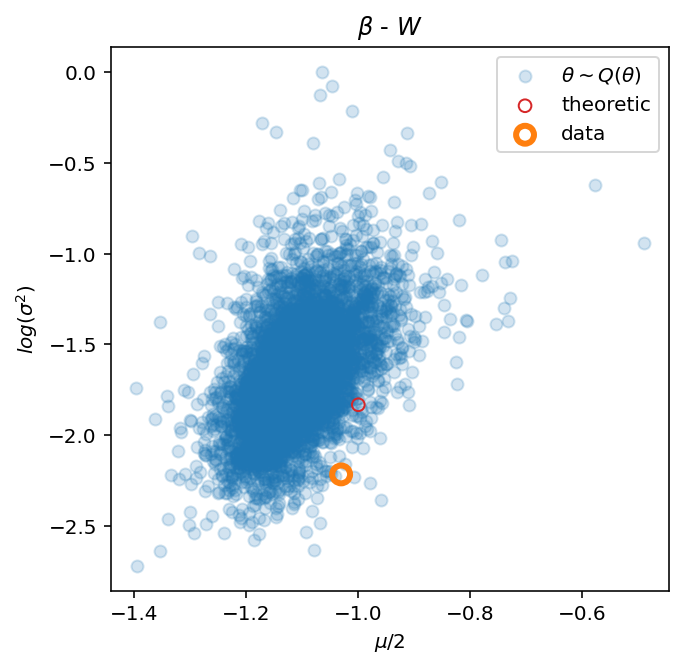

In [314]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.set_title(r"$\beta$ - $W$")

ax.scatter(zk_theta.data[:, 3], zk_theta.data[:, 5], 
           color='C0', alpha=0.2, label=r"$\theta \sim Q(\theta)$")

# Plot truth
ax.scatter(mu[1]/2, np.log(sg_w[1]**2), edgecolors='C3', alpha=1, 
           label='theoretic', facecolors='none', s=40)
ax.scatter(np.mean(Z[:, 1])/2, np.log(np.std(Zw[:, 1])**2), 
           facecolors='none', edgecolors='C1', alpha=1, s=80,
           linewidths=3, label="data")
ax.set_xlabel("$\mu /2$")
ax.set_ylabel("$log(\sigma^2)$")
ax.legend();